# 7: The Upper Confidence Bound (UCB) Algorithm

The **UCB algorithm** addresses the exploration-exploitation trade-off by applying the **principle of optimism in uncertainty**

### 1. Clearest advantages over ETC (this is from the textbook directly—later think of disadvantages)
* UCB functions without needing to know the suboptimality gaps. ETC needs to know it for the $O(\sqrt n)$ algorithm, and goes to $O(n^\frac{2}{3})$ without this knowledge.

* The algorithm generalizes well if there's more than two arms (ETC bounds are well proven for 2 arms, and worse for >2)

### 2. The Optimism Principle
The core idea is to act as if the environment is as "nice" as plausibly possible.
* The algorithm assigns each arm an **Upper Confidence Bound (UCB)** that is, with high probability, an overestimate of its true mean $\mu$.

* Each round, choose the arm with the largest UCB, also known as **index**. This is calculated as a function of empirical mean and number of times sampled: it should favor the arms with greater mean and favor the arms less sampled so far—somehow balancing these two considerations.

* This (probably) settles to a state where suboptimal arms' indexes fall below the optimal one.

* **Intuition**: The "optimism" encourages exploration, because it's consistent with the idea of "trying" something you don't know. It is a natural way to incorporate an **incentive to explore**.



### 3. Algorithm: UCB($\delta$)
This is the overview of the main loop in the algorithm, where $UCB(...)$ is a function that scores how good of an idea it is to try that arm next. We look at the derivation of $UCB(...)$ after this.

1. **Input**: Number of arms $k$ and error probability $\delta$.
2. **For** $t \in 1, \dots, n$:
    * Choose action $A_t = \text{argmax}_i \ UCB_i(t-1, \delta).
    * Observe reward $X_t$ and update empirical means and counts.

### 4. The UCB Formula
As mentioned, the index has to be somehow based on the empirical mean $\hat{\mu}_i(t-1)$ and the number of times it has been played $T_i(t-1)$.

$$UCB_i(t-1, \delta) = 
\begin{cases} 
\infty & \text{if } T_i(t-1) = 0 \\
\hat{\mu}_i(t-1) + \sqrt{\frac{2 \log(1/\delta)}{T_i(t-1)}} & \text{otherwise}
\end{cases}$$

Rationale: We want the index to overestimate the true mean $\mu_i$ but not by too much. $UCB(t-1, \delta)$ gives an overestimate that is “reasonable” as it has ≤ 𝛅 probability of underestimating the true mean, i.e. 1-𝛅 probability of indeed being an overestimate.

This probability bound comes from the **Cramer-Chernoff Method** for 1-subgaussian noise (Eqn 5.6 in the book) which says for $0<\delta<1$, with probability $1-\delta$,

$\mu \le \hat{\mu} + \sqrt{\frac{2 \sigma^2 \log(1/\delta)}{n}}$.

And with this $1-\delta$ bound on overestimation probability, we can push inequalities to obtain nice upper bounds on the regret (see next part).


Hence we have the UCB split into two parts: the first term is clearly the empirical mean based on history, and the second term is our exploration bonus which nudges us toward exploring. The "2" in the formula comes from the Cramer-Chernoff bound, but now in this form it is simply another hyperparameter.

> If "2" is changed to some other constant, what would change / break?

Practically, the algorithm would just shift towards either the explore or exploit more. 

But mathematically, it would no longer be the case that we have a $1-\delta$ probability of overestimate, as we are no longer using the correct bound which inspired the formula. This also implies that the proof of Theorem 7.1 (an upper bound on Regret) no longer holds, and we lose the Regret achievability.


### 5. Regret Analysis
UCB provides strong theoretical guarantees for the expected regret ($R_n$).

| Type of Bound | Formula | Description |
| :--- | :--- | :--- |
| **Problem-Dependent** | $R_n \le 3 \sum_{i=1}^{k} \Delta_i + \sum_{i:\Delta_i > 0} \frac{16 \log(n)}{\Delta_i}$ | Scales with the reciprocal of the gaps |
| **Problem-Independent** | $R_n \le 8 \sqrt{nk \log(n)} + 3 \sum_{i=1}^{k} \Delta_i$ | Worst-case bound that is nearly optimal |

---

### 6. The textbook's empirical performance
Experiment 7.1 demonstrates that while a perfectly tuned ETC (with known $\Delta$) may slightly outperform UCB, **UCB is generally superior** when the suboptimality gaps are unknown.

I'll try to reproduce their results and hopefully generate insights of my own.

## DO SOME EXPERIMENTS

In [130]:
import numpy as np

class BernoulliBandit:
    def __init__(self, means):
        self.means = means
        self.K = len(means)

    def pull(self, arm):
        return np.random.rand() < self.means[arm]

class GaussianBandit:
    def __init__(self, means, stds=None):
        self.means = means
        self.K = len(means)
        # allow either a single shared std or per‑arm stds
        if stds is None:
            self.stds = np.ones(self.K) # sigma=1 by default
        else:
            self.stds = np.array(stds)

    def pull(self, arm):
        return np.random.normal(self.means[arm], self.stds[arm])


In [43]:


class UCBdelta:
    def __init__(self, K, delta, c=2):
        self.K = K
        self.delta = delta
        self.c = c
        self.counts = np.zeros(K)          # N_i(t)
        self.means = np.zeros(K)           # empirical means μ̂_i(t)
        self.t = 0

    def index(self, i):
        # If arm i has never been pulled: UCB_i(t) = +∞
        if self.counts[i] == 0:
            return float('inf')

        # Otherwise: μ̂_i(t) + sqrt( (2 log(1/δ)) / N_i(t) )
        return self.means[i] + np.sqrt((self.c * np.log(1 / self.delta)) / self.counts[i])

    def select_arm(self):
        # argmax_i UCB_i(t)
        indices = [self.index(i) for i in range(self.K)]
        return int(np.argmax(indices))

    def update(self, arm, reward):
        self.t += 1
        self.counts[arm] += 1
        n = self.counts[arm]

        # Update empirical mean: μ̂_i ← μ̂_i + (r - μ̂_i)/N_i
        self.means[arm] += (reward - self.means[arm]) / n


# --- Simulation ---
def run_ucb_delta(means, delta, horizon, env):
    agent = UCBdelta(len(means), delta)
    rewards = []
    choices = []

    for _ in range(horizon):
        arm = agent.select_arm()
        r = env.pull(arm)
        agent.update(arm, r)
        rewards.append(r)
        choices.append(arm)

    return np.array(rewards), np.array(choices)




In [78]:
means = [0.2, 0.3, 0.5, 0.6, 0.8]
horizon = 5000
delta = 1/horizon**2
env = BernoulliBandit(means)

rewards, choices = run_ucb_delta(means, delta, horizon, env)
np.mean(rewards)

0.7416

### Plot: % of optimal guesses in fixed segments over time

#### Things I wanted to look out for:
* Sanity check: it should generally increase from 0 to 100, and hover around 100
* Smoothness of the increase
* Once it's about settled at 100, how frequently / violently it might randomly worsen at times
* How long it takes to converge, w.r.t. how difficult the bandit problem instance is

In [92]:
import matplotlib.pyplot as plt

def optimal_arm_percentages(chosen_arms, true_means, num_segments):
    n = len(chosen_arms)
    K = len(true_means)

    # Identify the optimal arm: argmax_i μ_i
    optimal = int(np.argmax(means))

    # Split horizon into equal segments
    segment_size = n // num_segments
    percentages = []

    for k in range(num_segments):
        start = k * segment_size
        end = (k + 1) * segment_size if k < 9 else n  # last segment takes remainder

        segment = chosen_arms[start:end]

        # % optimal = (# times optimal arm chosen) / (segment length)
        pct = np.mean(segment == optimal) * 100
        percentages.append(pct)

    segments = np.arange(1, num_segments+1)

    plt.figure(figsize=(15, 4)) 
    plt.plot(segments, percentages, marker='o')
    plt.xticks(segments)
    plt.xlabel("Segment")
    plt.ylabel("Percent optimal arm chosen")
    plt.title("Optimal Arm Selection Rate Over Time")
    plt.grid(True)
    plt.show()





In [96]:
def experiment_plot_optimal_arm(means, delta, horizon, env, num_seg):
    rewards, choices = run_ucb_delta(means, delta, horizon, env)
    optimal_arm_percentages(choices, means, num_seg)
    # This is not for visualizing existing results.
    # Every time this is run, we do a fresh simulation.

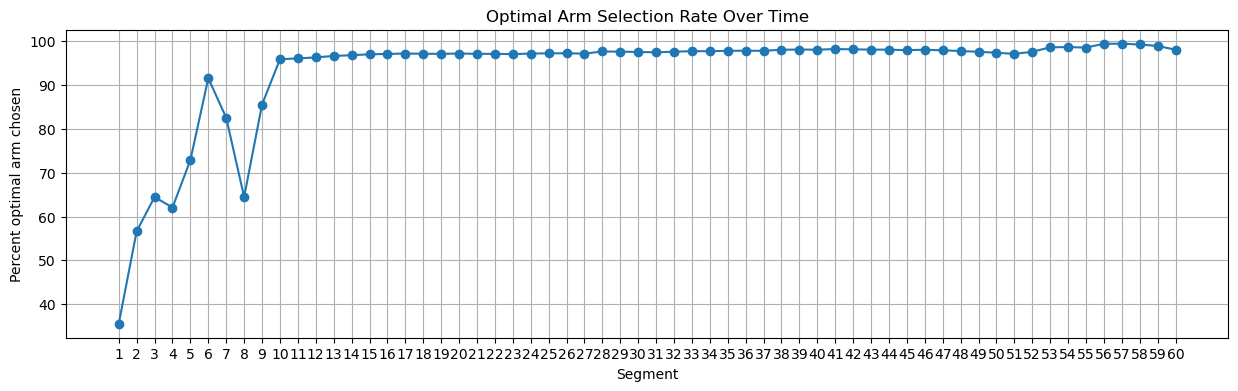

In [112]:
means = [0.2, 0.3, 0.5, 0.6, 0.8]
horizon = 10000
delta = 1/horizon**2
env = BernoulliBandit(means)
experiment_plot_optimal_arm(means, delta, horizon, env, 60)

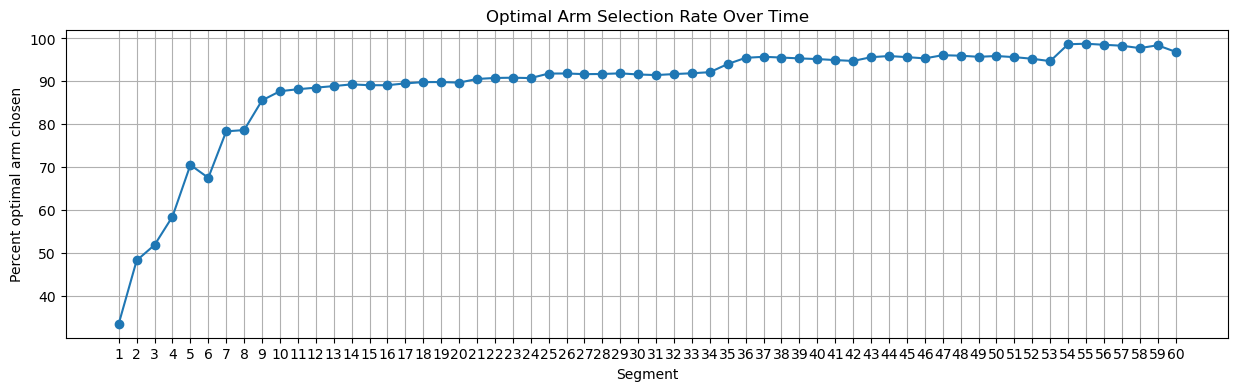

In [119]:
means = [0.3, 0.4, 0.5, 0.6, 0.7] # harder problem
horizon = 20000
delta = 1/horizon**2
env = BernoulliBandit(means)
experiment_plot_optimal_arm(means, delta, horizon, env, 60)

Now for Gaussians (all sigma=1)

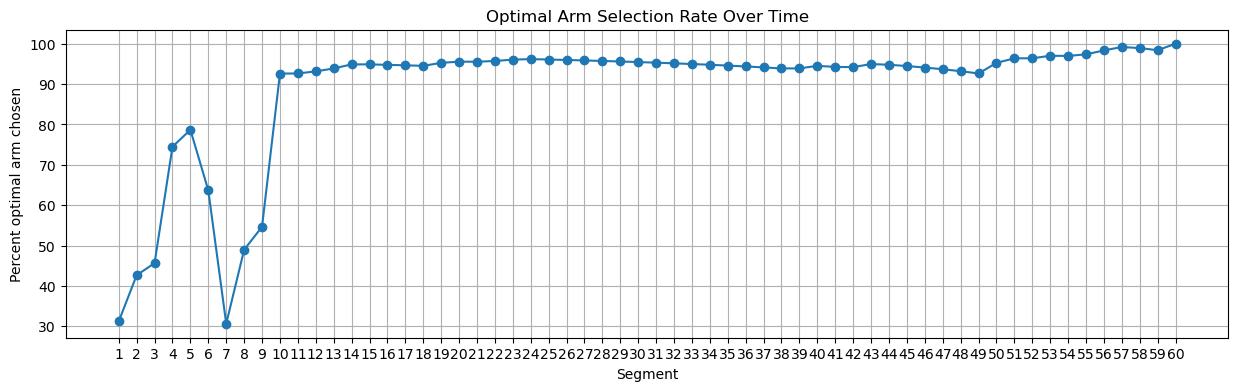

In [141]:
means = [0.3, 0.4, 0.5, 0.6, 0.7] # harder problem
horizon = 20000 # doubled the horizon (it does have 4x the variance)
delta = 1/horizon**2
env = GaussianBandit(means)
experiment_plot_optimal_arm(means, delta, horizon, env, 60)

### Plotting realized regret against "2" hyperparameter in UCB
We define it as $c$. By default $c = 2$ so I started with the range $1 \le c \le 3$. Then I noticed smaller $c$ seemed to consistently win so I shifted further to $0 \le c$.
#### Things to look out for
* Sanity check: first check that nothing breaks in practice as we tune $c$
* Whether the curve will be roughly convex with one optimum
* How much best $c$ might depend on problem instance

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# --- regret for a single run ---
def compute_regret(rewards, means):
    optimal_mean = np.max(means)
    t = len(rewards)
    return t * optimal_mean - np.sum(rewards)

# --- sweep c values and compute regret ---
def regret_vs_c(means, delta, horizon, env, c_min=0, c_max=3, reps=5):
    c_values = np.arange(c_min, c_max, 0.1)
    regrets = []

    for c in c_values:
        tot_regret = 0
        for rep in range(reps):
            agent = UCBdelta(len(means), delta, c)
            env = BernoulliBandit(means)

            rewards = []
            for _ in range(horizon):
                arm = agent.select_arm()
                r = env.pull(arm)
                agent.update(arm, r)
                rewards.append(r)
            tot_regret += compute_regret(rewards, means)

        regrets.append(tot_regret/reps)

    return c_values, regrets


def plot_regret_vs_c(c_values, regrets):
    plt.figure(figsize=(15, 4))
    plt.plot(c_values, regrets, marker='o')
    plt.xlabel("c parameter")
    plt.ylabel("Regret")
    plt.title("Regret vs. c for UCB(c)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()




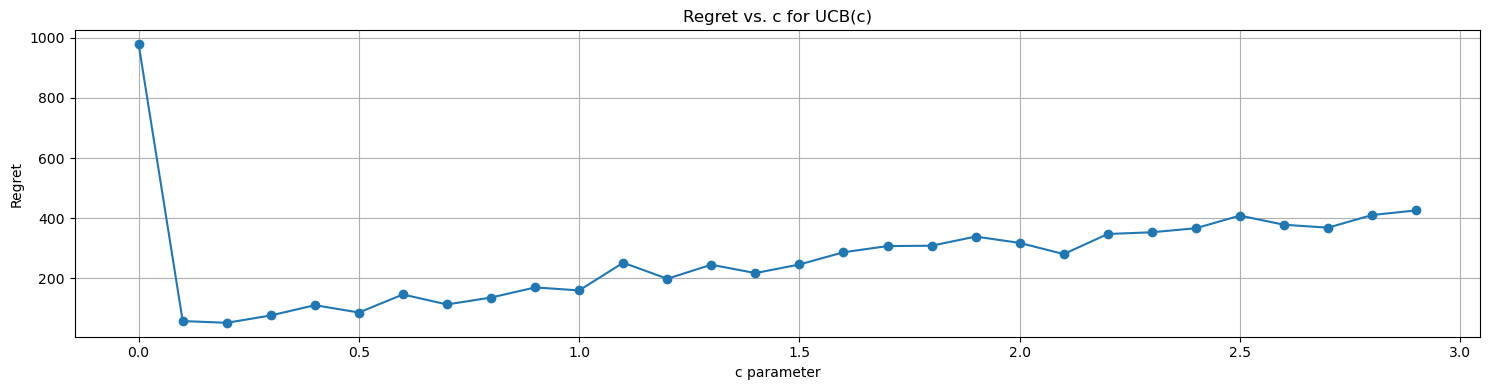

In [154]:
means = [0.3, 0.4, 0.5, 0.6] # difficult problem
horizon = 10000
delta = 1/horizon**2
c_values, regrets = regret_vs_c(means,delta, horizon, BernoulliBandit)
plot_regret_vs_c(c_values, regrets)

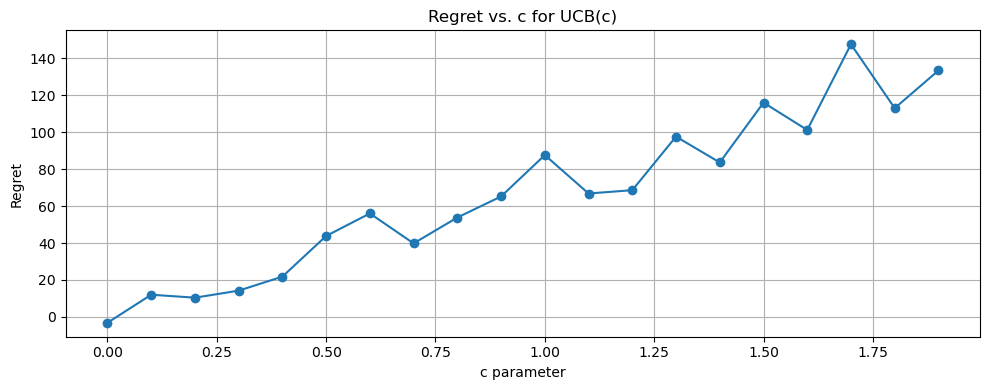

In [129]:
means = [0.2, 0.3, 0.4, 0.9] # easier problem
horizon = 5000
delta = 1/horizon**2
c_values, regrets = regret_vs_c(means,delta, horizon, BernoulliBandit)
plot_regret_vs_c(c_values, regrets)

#### Thoughts
These Bernoulli bandit problems are too easy, and variance is too small. Not much exploration is needed, so optimal $c$ shrinks. We try Gaussians next.

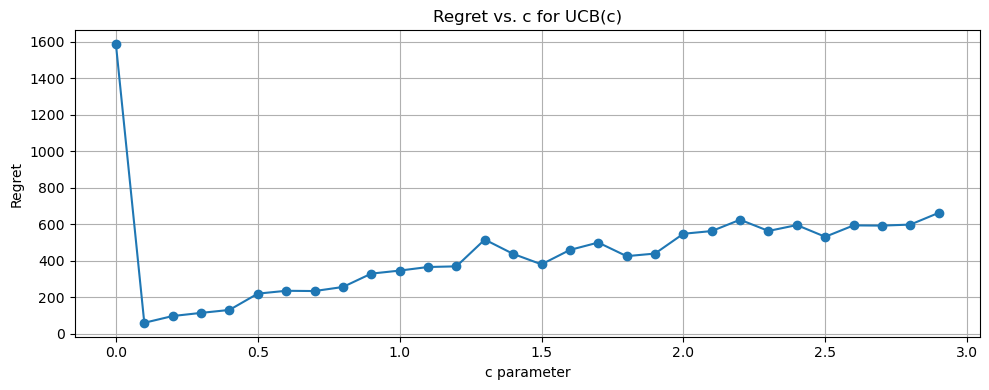

In [152]:
means = [0.4, 0.4, 0.4, 0.5] # difficult problem
horizon = 20000
delta = 1/horizon**2
c_values, regrets = regret_vs_c(means,delta, horizon, GaussianBandit)
plot_regret_vs_c(c_values, regrets)

### Plotting realized regret against delta

Textbook analysis uses $\delta=\frac{1}{n^2}$ but let's try some larger values?

In [159]:
def regret_vs_delta(means, horizon, c=2, reps=3):
    n = horizon
    delt_1 = 1/n
    delt_2 = 1/n**2
    delta_values = [0.5 * delt_2, delt_2, 0.5*(delt_1+delt_2), delt_1, 2*delt_1]
    regrets = []

    for delta in delta_values:
        tot_regret = 0
        for rep in range(reps):
            agent = UCBdelta(len(means), delta, c) 
            env = BernoulliBandit(means)

            rewards = []
            for _ in range(horizon):
                arm = agent.select_arm()
                r = env.pull(arm)
                agent.update(arm, r)
                rewards.append(r)
            tot_regret += compute_regret(rewards, means)

        regrets.append(tot_regret/reps)

    return delta_values, regrets

def plot_regret_vs_delta(delta_values, regrets):
    plt.figure(figsize=(10, 4))
    plt.plot(delta_values, regrets, marker='o')
    plt.xlabel("delta")
    plt.ylabel("Realized regret")
    plt.title("Realized regret vs. delta for UCB(delta)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



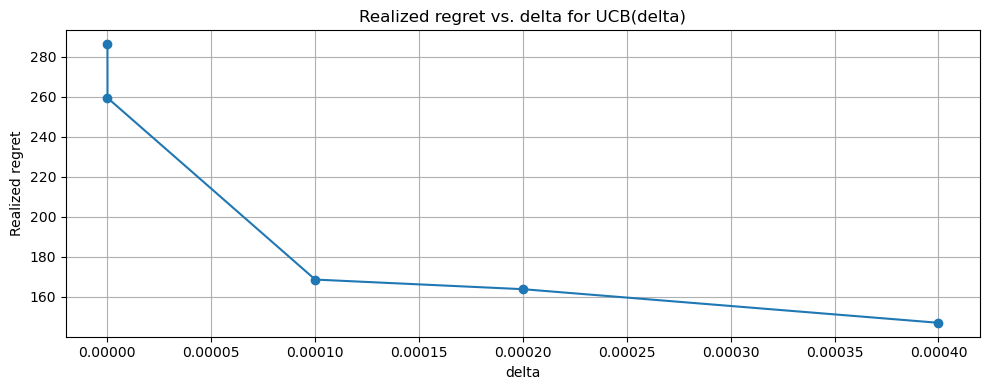

In [160]:
delta_values, regrets = regret_vs_delta(means=[0.2,0.3,0.4,0.5,0.6], horizon=5000, c=2, reps=5)
plot_regret_vs_delta(delta_values, regrets)

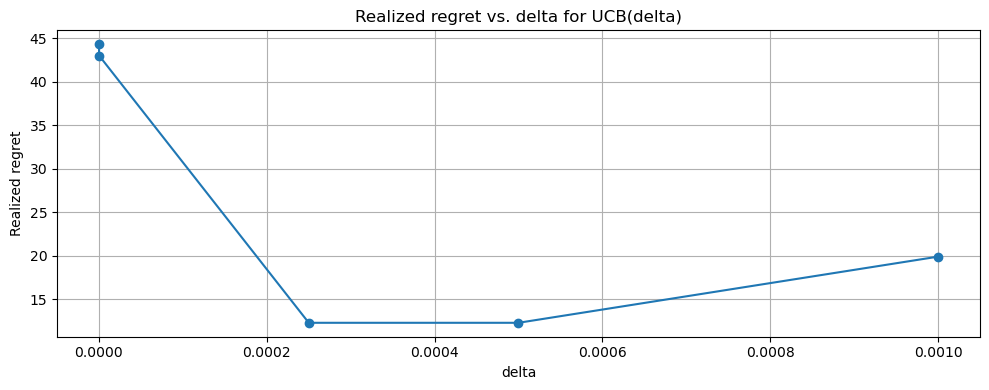

In [161]:
delta_values, regrets = regret_vs_delta(means=[0.2,0.7], horizon=2000, c=2, reps=10)
plot_regret_vs_delta(delta_values, regrets)

In [ ]:
###Later: I want to run simulation where each time we randomly sample a game instance from a larger environment class, and then run the strategy on it. And this should be done a few times (including re-sampling the game instance) and we take average performance.
# Instead of what I'm doing now, which is getting one particular environment 

To look more into:
* the role played by how to choose $\delta := some\_function(n)$
* plot easy settings vs hard settings (close to uniform)